In [1]:
import torch
import matplotlib.pyplot as plt
from imageio import imread
import cv2
import numpy as np
# 导入相关包
from utils.data.jacquard_data_t import JacquardDataset
from models.ggcnn2_patch_v4 import GGCNN2
from models.common import post_process_output
from utils.dataset_processing import evaluation
from utils.dataset_processing.evaluation import collision_validate
from utils.dataset_processing.grasp import Grasp

In [2]:
model_path = 'output/models/ggcnn2_v4/epoch_41_iou_0.93_statedict.pt'
net = GGCNN2(1)
net.load_state_dict(torch.load(model_path))

device = torch.device("cuda:0")
val_imgs = ['pos','cos','sin','width']

net = net.to(device)

In [3]:
dataset = JacquardDataset('../jacquard/',start = 0.0, end = 1.0, random_rotate = True, random_zoom = True, include_depth = True, include_rgb = False)

In [4]:
val_data = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=8
    )

In [5]:
def validate(net, device, val_data, batches_per_epoch,val_imgs):
    """
    Run validation.
    :param net: Network
    :param device: Torch device
    :param val_data: Validation Dataset
    :param batches_per_epoc,h: Number of batches to run
    :return: Successes, Failures and Losses
    """
    net.eval()

    results = {
        'correct': 0,
        'failed': 0,
        'loss': 0,
        'positive':0,
        'negative':0,
        'losses': {},
        'perfect':0,
        'not_perfect':0,
        'fname':[],
        'gr_para':[],
    }
    for i in range(20):
        results['positive_'+str(i)] = 0
        results['negative_'+str(i)] = 0

    ld = len(val_data)

    with torch.no_grad():
        batch_idx = 0
        while batch_idx < batches_per_epoch:
            for x, y, didx, rot, zoom_factor in val_data:
                batch_idx += 1
                print(batch_idx)
                if batches_per_epoch is not None and batch_idx >= batches_per_epoch:
                    break
                filename = val_data.dataset.grasp_files[didx].split('/')[-1][:-11]
#                 print(didx)
#                 print(rot)
#                 print(zoom_factor)
                print(filename)
#                 print(val_data.dataset.grasp_files[didx])
                xc = x.to(device)
                yc = [yy.to(device) for yy in y]
                lossd = net.compute_loss(xc, yc)

                loss = lossd['loss']

                results['loss'] += loss.item()/ld
                for ln, l in lossd['losses'].items():
                    if ln not in results['losses']:
                        results['losses'][ln] = 0
                    results['losses'][ln] += l.item()/ld

                q_out, ang_out, w_out = post_process_output(lossd['pred'][val_imgs[0]], lossd['pred'][val_imgs[1]],
                                                            lossd['pred'][val_imgs[2]], lossd['pred'][val_imgs[3]])

                gs,s = evaluation.calculate_iou_match(q_out, ang_out,
                                                   val_data.dataset.get_gtbb(didx, rot, zoom_factor),
                                                   no_grasps=1,
                                                   grasp_width=w_out,
                                                   )

                if s:
                    results['correct'] += 1
                else:
                    results['failed'] += 1
                
                # 真实精度检测
                if len(gs) > 0:
                    edge, lr_congruous, tb_congruous = collision_validate(gs[0].as_gr,yc[5])
#                     print(gs[0].center)
#                     print(gs[0].angle)
#                     print(gs[0].width)
                    gr = gs[0].as_gr
                    gr.rotate(-rot,(150,150))
                    gr.zoom(1/zoom_factor.numpy(), [150,150])
                    gr = Grasp(center = gr.center * 1024/300, angle = gr.angle, length = gr.length * 1024 /300, width = gr.width * 1024 /300).as_gr
                    results['fname'].append(filename)
                    results['gr_para'].append('{};{};{};{};{}'.format(gr.center[1],gr.center[0],-gr.angle/3.14*180,gr.length,gr.width))
                    print('{};{};{};{};{}'.format(gr.center[1],gr.center[0],-gr.angle/3.1415*180,gr.length,gr.width))
                    img = val_data.dataset.get_rgb(didx,rot = rot, zoom = zoom_factor, normalise=False)
                    origin_img = imread(val_data.dataset.rgb_files[didx])
                    show_grasp(img,gs[0].as_gr)
                    show_grasp(origin_img,gr)
                    for edge_threshold in range(0,20):
                        if edge > edge_threshold:
                            results['positive_'+str(edge_threshold)] += 1
                        else:
                            results['negative_'+str(edge_threshold)] += 1
                    if lr_congruous < 0.85 and tb_congruous < 0.85:
                        results['perfect'] += 1
                    else:
                        results['not_perfect'] += 1
                else:
                    for edge_threshold in range(0,20):
                        results['negative_'+str(edge_threshold)] += 1
                    results['not_perfect'] += 1
    return results
def show_grasp(img,grasp,color = (0,255,0),title = 'Show Grasp',dis = True):
    # 给定一张图及一个抓取(Grasps和Grasp类型均可),在图上绘制出抓取框
    gr = grasp
#     print(gr.points.astype(np.uint32))
    # 有时候预测出负值会报错
    try:
        for i in range(3):
            cv2.line(img,tuple(gr.points.astype(np.uint32)[i][::-1]),tuple(gr.points.astype(np.uint32)[i+1][::-1]),color,1)
        cv2.line(img,tuple(gr.points.astype(np.uint32)[3][::-1]),tuple(gr.points.astype(np.uint32)[0][::-1]),color,1)
        cv2.circle(img, (gr.center[1],gr.center[0]), 2, color, 1)
    except Exception as e:
        print(e)
        pass
    if dis:
        plt.figure(figsize=(5,5))
        plt.title(title)
        plt.imshow(img)
        plt.show()

    return img

1
0_1a0312faac503f7dc2c1a442b53fa053
539;501;40.15718396282062;142.91231686286213;73.04852329483171


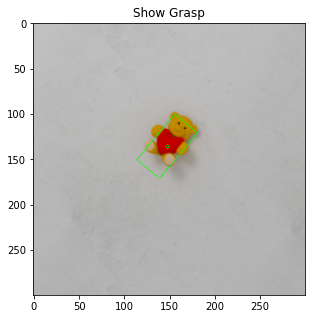

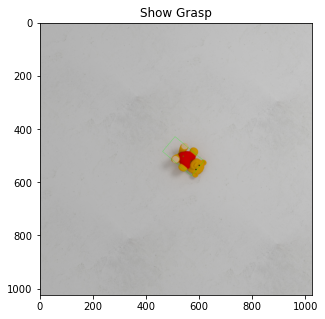

2
1_1a0312faac503f7dc2c1a442b53fa053
535;525;50.35731020852676;155.14717084826984;75.17086906212776


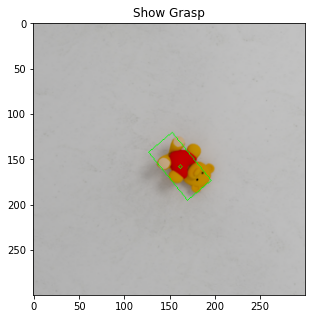

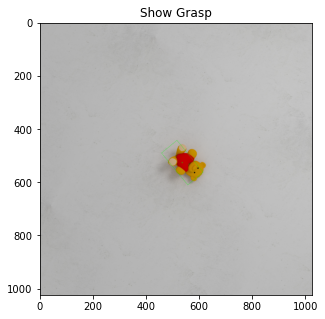

3
2_1a0312faac503f7dc2c1a442b53fa053
542;477;76.2659809729108;158.1224594350144;80.34032500694907


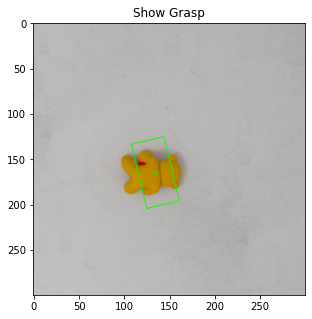

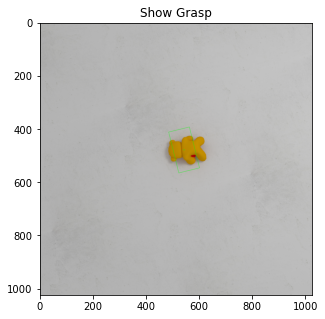

4
3_1a0312faac503f7dc2c1a442b53fa053
556;494;84.56216192308933;144.00869109574995;72.00434554787499


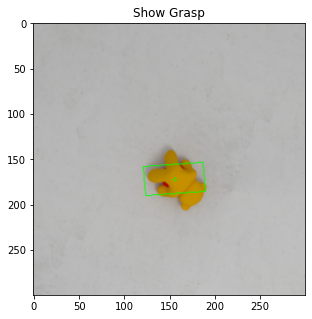

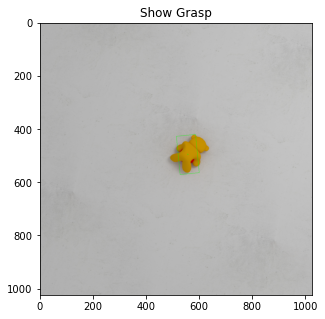

5
4_1a0312faac503f7dc2c1a442b53fa053
566;570;-22.30686294125901;143.88728428105725;73.52545016674314


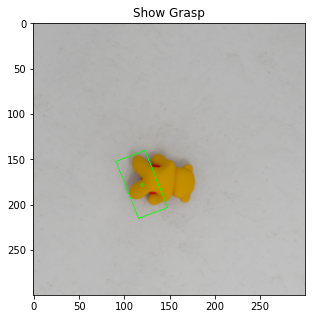

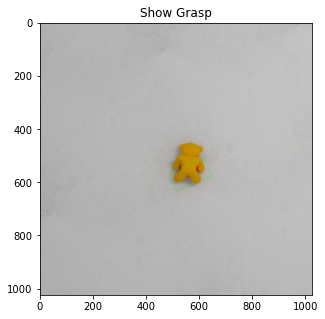

6
0_1a03376343b2e4f0c27d3c9a6f742a5e
634;488;82.05894831734297;148.19528257599083;68.6071509068519


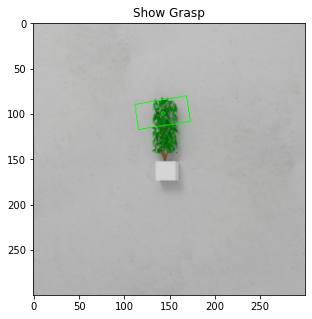

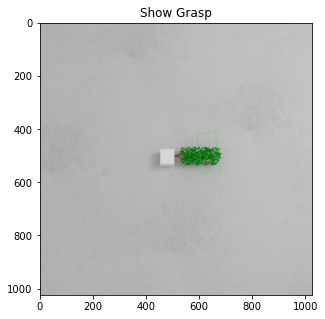

7
1_1a03376343b2e4f0c27d3c9a6f742a5e
522;583;39.95872741574002;164.76185103219592;79.97695668128418


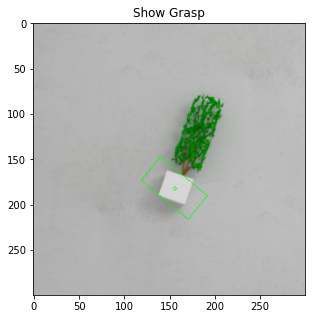

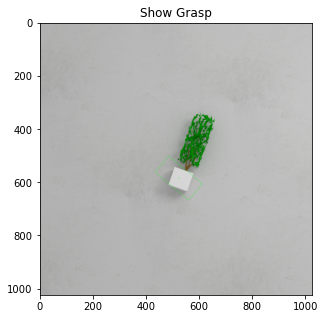

8
2_1a03376343b2e4f0c27d3c9a6f742a5e
505;501;66.0394586976986;134.46973852052287;70.3676693438747


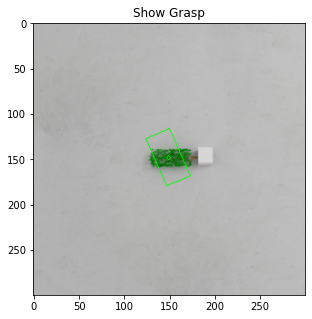

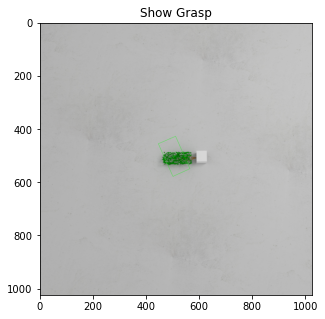

9
3_1a03376343b2e4f0c27d3c9a6f742a5e
651;546;70.20319411694196;181.38904242293998;90.69452121146992


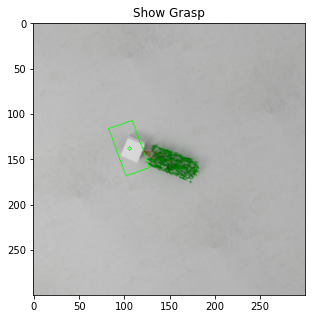

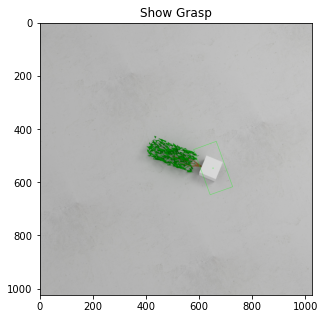

10
4_1a03376343b2e4f0c27d3c9a6f742a5e
532;542;28.142431224423625;166.45031717869716;85.53788816139381


In [ ]:
results = validate(net, device, val_data, 250, val_imgs = val_imgs)

In [ ]:
results

In [ ]:
with open('test10_v4.txt','w') as f:
    for i in range(len(results['fname'])):
        f.write(results['fname'][i])
        f.write('\n')
        f.write(results['gr_para'][i])
        f.write('\n')

In [ ]:
for i in range(len(dataset.grasp_files)):
    if '4_244cc8707720b66bac7e7b41e1ebe3e4' in dataset.grasp_files[i]:
        print(dataset.grasp_files[i])
# 332.5442;439.15298;74.466;28.5;25.5461

In [ ]:
%matplotlib auto
gr = Grasp(center = (486,508), angle = 8/180*3.1415,length = 25,width = 10)
img = imread('../jacquard/Jacquard_Dataset_4/244cc8707720b66bac7e7b41e1ebe3e4/4_244cc8707720b66bac7e7b41e1ebe3e4_RGB.png')
img = show_grasp(img,gr.as_gr)

In [ ]:
img = show_grasp(img,gr.as_gr)

In [ ]:
with open('Result.txt', 'r') as f:
    success = 0
    i = 0
    a = 1
    while a!= '':
        a = f.readline()
        if len(a) < 10:
            i+=1
            if a == '0\n':
                success += 1
                print(i)

In [ ]:
# In GGCNN code ,length is the opening width of the claw.

In [ ]:
success